In [1]:
import math
import re
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit, least_squares
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import functools
import multiprocessing
import difflib

In [2]:
news = pd.read_csv("res/warc_pages.csv")
# news = pd.concat((news, pd.read_csv("res/news2_temp.csv")))
news = news[news["text"].notna()]
news["original_url"] = news["original_url"].str.strip()
news = news[~news["original_url"].isin({"https://sero.gcloud.api.no:443/", "http://sero.gcloud.api.no/"})]
news = news.groupby("original_url").filter(lambda x: len(x) >= 100)
news = news.sort_values("timestamp")
news.describe()

,Unnamed: 0,timestamp,norvegica_score,language.text_bytes_found,language.details.0.percent,language.details.0.score,language.details.1.percent,language.details.1.score,language.details.2.percent,language.details.2.score,...,regex.county.unique,regex.county.total,regex.name.unique,regex.name.total,regex.norway.unique,regex.norway.total,regex.kroner.unique,regex.kroner.total,regex.email.unique,regex.email.total
count,31080.000000,3.108000e+04,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,...,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000,31080.000000
mean,45320.922555,1.587886e+09,0.950073,9085.293855,96.518790,826.540283,0.828861,122.802156,0.075064,11.359202,...,1.369723,3.930534,1.859202,2.499614,1.256821,3.944981,0.636486,0.858977,1.247072,1.359459
std,29097.739147,1.938948e+06,0.042613,11679.092760,11.648883,128.222696,3.096030,300.465196,0.739544,101.862492,...,3.427866,7.690205,3.170843,4.371765,1.144335,7.178043,1.026171,1.641479,2.235152,2.356825
min,0.000000,1.584097e+09,0.000000,11.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20788.750000,1.586118e+09,0.937500,3584.000000,99.000000,784.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,41213.500000,1.587825e+09,0.962595,6170.500000,99.000000,836.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000
75%,67903.500000,1.589609e+09,0.978654,11096.250000,99.000000,884.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,4.000000,2.000000,3.000000,2.000000,5.000000,1.000000,1.000000,1.000000,2.000000
max,105072.000000,1.591085e+09,0.996367,142032.000000,99.000000,4100.000000,48.000000,6702.000000,12.000000,5617.000000,...,37.000000,60.000000,33.000000,41.000000,5.000000,74.000000,12.000000,19.000000,21.000000,21.000000


In [3]:
schemes = ["dice", "cosine", "jaccard"]

def similarity_coeffs(A, B):
    intersect = A & B
    absA = sum(A.values())
    absB = sum(B.values())
    absI = sum(intersect.values())
    dice = 2 * absI / (absA + absB)
    cosine = absI / (math.sqrt(absA * absB))
    jacc = absI / (absA + absB - absI)
    return dice, cosine, jacc

def get_all_diffs(df, adjust=False):
    diffs = {
        scheme: np.eye(len(df) or None, dtype=float)
        for scheme in schemes
    }
    counters = [Counter(re.split("\\W+", s.lower())) for s in df["text"]]
#     const = functools.reduce(Counter.__and__, counters) if adjust else Counter()
    for i, c1 in enumerate(counters):
        for j, c2 in enumerate(counters[:i]):
            sims = similarity_coeffs(c1, c2)
            for scheme, sim in zip(schemes, sims):
                diffs[scheme][i][j] = sim
                diffs[scheme][j][i] = sim
    return diffs

def g(x, a, b):
    x = np.abs(x)
#     return (1 - c) / (b * x + 1) + c
#     return (1-a) * ((1-b) * c ** x + b * d ** x) + a
#     return b ** x
#     return b / (x + b)
#     return (1-a) / (1 + (1/b-1) * x) + a
#     return (1 + a * (1/b - 1) * x) / (1 + (1/b - 1) * x)
#     return 1 / (a * x / (b + x) + 1)
    return 1 / (a * np.log1p(b*x) + 1)

def get_params(diffs, timestamps):
    params = {}
    fitness = {}
    xg = np.array([(ts1 - ts0) / 3600 for ts0 in timestamps for ts1 in timestamps])
    for scheme, diff in diffs.items():
        yg = diff.flatten()
        g_params = curve_fit(g, xg, yg, p0=[1, 1], bounds=(0, np.inf), maxfev=1000)[0]
        params[scheme] = g_params
        fitness[scheme] = {
            "r2": r2_score(yg, g(xg, *g_params)),
            "mse": mean_squared_error(yg, g(xg, *g_params))
        }
    return params, fitness

def get_info(website):
    df = news[news["original_url"] == website]
    diffs = get_all_diffs(df)
    params, fitness = get_params(diffs, df["timestamp"].array)
    
    info = {
        scheme: {
            "diffs": diffs[scheme],
            "params": params[scheme],
            "fitness": fitness[scheme]
        } for scheme in schemes
    }
    info["timestamps"] = df["timestamp"].array
    return info

def div_diff(t1, t2):
#     t1, t2 = t1.split("\t"), t2.split("\t")
    chars = " +-?"
    sets = set(), set(), set(), set()  # same, added, removed, neither
    for comp in difflib.Differ().compare(t1, t2):
        line = comp[2:]
        first = comp[0]
        for c, s in zip(chars, sets):
            if first == c:
                s.add(line)
                break
    return sets

def foo(arg):
    split, c1 = arg
    sims = []
    for j, c2 in enumerate(split):
        s, a, r, n = div_diff(c1, c2)
        changes = len(a-r)
        sim = 1 - changes / (len(s) + changes)
#             diffs[i][j] = sim
#             diffs[j][i] = sim
        sims.append(sim)
    return sims

def get_div_diffs(website):
    df = news[news["original_url"] == website]
    diffs = np.eye(len(df) or None, dtype=float)
    splits = [s.split("\t") for s in df["text"]]
#     const = functools.reduce(Counter.__and__, counters) if adjust else Counter()
#     print(len(splits))
    diffs = []
    s1 = splits[len(splits) // 4]
    for s2 in splits:
        s, a, r, n = div_diff(s1, s2)
        changes = len(a-r)
        sim = 1 - changes / (len(s) + changes)
        diffs.append(sim)

    return diffs


In [4]:
pool = multiprocessing.Pool(6)
names = news["original_url"].unique()
info_dict = dict(zip(names, pool.map(get_info, names)))
pool.close()
# info_dict = {
#     ws: get_info(ws)
#     for ws in news["original_url"].unique()
# }

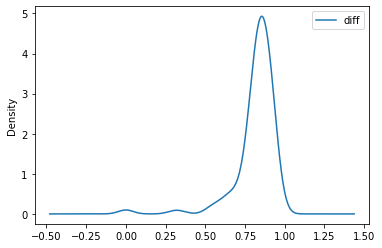

In [5]:
vals = [info_dict[ws]["jaccard"]["fitness"]["r2"] for ws in info_dict]
# plt.hist(vals)
pd.DataFrame(vals, columns=["diff"]).plot.kde()
plt.savefig("density.png")

{'cosine': {'fitness': {'mse': 0.0004273357888198204, 'r2': 0.9016069608545456},
            'params': array([0.15337925, 1.07165036])},
 'dice': {'fitness': {'mse': 0.00042857240392832417, 'r2': 0.9013748378267545},
          'params': array([0.15352606, 1.07250164])},
 'jaccard': {'fitness': {'mse': 0.0004815791552915215,
                         'r2': 0.9158466164592328},
             'params': array([0.3302604 , 0.71404562])}}


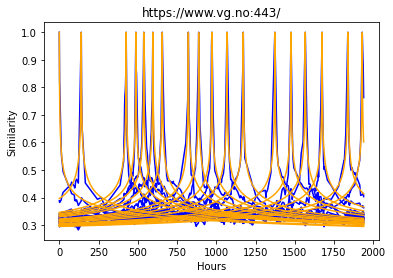

In [15]:
from pprint import pprint

def plot(site, skip, scheme="cosine"):
    stamps = info_dict[site]["timestamps"]
    stamps = np.array((stamps - stamps[0]) / 3600)
    params = info_dict[site][scheme]["params"]
    diffs = info_dict[site][scheme]["diffs"]
    [plt.plot(stamps, diffs[i], color="blue") for i in range(0, len(diffs), skip)]
    [plt.plot(np.arange(stamps[0], stamps[-1], 0.01), g(np.arange(-stamps[i], stamps[-1]-stamps[i], 0.01), *params), color="orange") 
         for i in range(0, len(diffs), skip)]
    plt.title(site)
    plt.xlabel("Hours")
    plt.ylabel("Similarity")
    plt.show()
get = "https://www.vg.no:443/"
pprint({scheme: {k: info_dict[get][scheme][k] for k in info_dict[get][scheme] if k != "diffs"} for scheme in schemes})
# print(info_dict[get]["timestamps"][1:]-info_dict[get]["timestamps"][:-1])
plot(get, 16, "jaccard")

In [7]:
sort_fitness = sorted([(ws, info_dict[ws]["jaccard"]["fitness"]["r2"]
                        + (1 - 2 * math.sqrt(info_dict[ws]["jaccard"]["fitness"]["mse"])))
                       for ws in info_dict], key=lambda x: x[::-1])
print(f"{sort_fitness[:10]}\n...\n{sort_fitness[10:-10:30]}\n...\n{sort_fitness[-10:]}")

[('http://www.norwaypost.no/', 0.9999994626149431), ('https://meloyavisa.no:443/', 0.9999994689399897), ('https://www.p4.no:443/', 1.1434967968295102), ('http://www.vestkantavisen.no/', 1.3367933286352995), ('https://www.hf.no:443/', 1.3550794171484486), ('http://frostingen.no/', 1.377630406393949), ('http://www.tysnesbladet.no/', 1.3967334927009027), ('https://www.blv.no:443/', 1.428929473092896), ('https://www.nytid.no:443/', 1.4371502669335618), ('https://www.eub.no:443/', 1.440466676900635)]
...
[('https://www.synste.no:443/', 1.4557482913333732), ('https://www.driva.no:443/', 1.7013887101223304), ('https://www.innherred.no:443/', 1.743569739514206), ('https://www.glomdalen.no:443/', 1.7703852484874938), ('https://www.rights.no:443/', 1.809658647144293), ('https://www.vikebladet.no:443/', 1.858758522117199)]
...
[('https://svalbardposten.no:443/', 1.8603972054049076), ('https://igjerstad.no:443/', 1.8617702758088206), ('https://idag.no:443/', 1.8658679887664205), ('https://www.vg.n

In [8]:
sort_params = sorted([(ws, info_dict[ws]["jaccard"]["params"][0])
                       for ws in info_dict], key=lambda x: x[::-1])
print(f"{sort_params[:10]}\n...\n{sort_params[10:-10:30]}\n...\n{sort_params[-10:]}")

[('http://www.norwaypost.no/', 1.6614302400534715e-05), ('https://meloyavisa.no:443/', 1.6907184476746148e-05), ('http://www.vestkantavisen.no/', 0.0004078571957700164), ('https://folldalsportalen.no:443/', 0.05755953267097025), ('https://mre.no:443/', 0.08555258691668002), ('https://www.p4.no:443/', 0.09158460191827104), ('https://saltenposten.no:443/', 0.09758062833341784), ('https://vaganavisa.no:443/', 0.11719096253201199), ('https://www.oyposten.no:443/', 0.12083696207817597), ('https://svalbardposten.no:443/', 0.12419685647041388)]
...
[('https://groruddalen.no:443/', 0.13538975999443512), ('https://www.smp.no:443/', 0.2889997418833612), ('https://drm24.no:443/', 0.38742768838162056), ('https://www.opdalingen.no:443/', 0.4829918770999978), ('https://www.fremover.no:443/', 0.6582759412909263), ('https://www.dagen.no:443/', 1.0638939064193607)]
...
[('http://www.reavisa.no/', 1.287045007980091), ('https://journalisten.no:443/', 1.2889756346028314), ('https://universitas.no:443/', 1

In [9]:
fit = [f for ws, f in sort_fitness if not math.isnan(f)]
print(sum(fit)/len(fit))

1.7265241588955262


296.9621553300305 -124.96215533003061


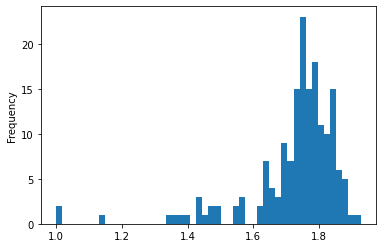

In [10]:
info_df = pd.DataFrame(fit, columns=["fit"])
info_df["fit"].plot.hist(bins=50)
print(sum(f for f in fit), sum(1-f for f in fit))

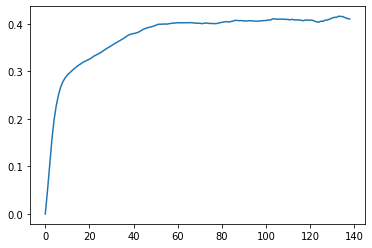

In [11]:
def nice(df, step=1):
    counters = [Counter(re.split("\\W+", s.lower())) for s in df["text"]]
    midsim = []
    for i in range(step, len(counters)-step):
        c1 = counters[i-step]
        c2 = counters[i]
        c3 = counters[i+step]
        # How much information does c2 contain which is not in c1 or c3
        a = c2 - (c1 | c3)
        midsim.append(sum(a.values())/sum(c2.values()))
    return sum(midsim) / len(midsim)

noice = news[news.original_url == "https://www.vg.no:443/"]
plt.plot([nice(noice, i) for i in range(len(noice) // 2)])
# print(res)

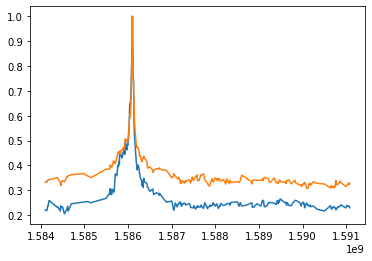

In [12]:
asd = "https://www.vg.no:443/"
dd = get_div_diffs(asd)
loc = len(dd) // 4
plt.plot(list(info_dict[asd]["timestamps"]), dd)
plt.plot(list(info_dict[asd]["timestamps"]), info_dict[asd]["jaccard"]["diffs"][loc])

[[1.         0.84659091 0.5863747  ... 0.21292776 0.21013133 0.20973783]
 [0.84659091 1.         0.6159601  ... 0.21455939 0.21172023 0.21132075]
 [0.5863747  0.6159601  1.         ... 0.21374046 0.21092279 0.21052632]
 ...
 [0.21292776 0.21455939 0.21374046 ... 1.         0.86646884 0.82608696]
 [0.21013133 0.21172023 0.21092279 ... 0.86646884 1.         0.94801223]
 [0.20973783 0.21132075 0.21052632 ... 0.82608696 0.94801223 1.        ]]


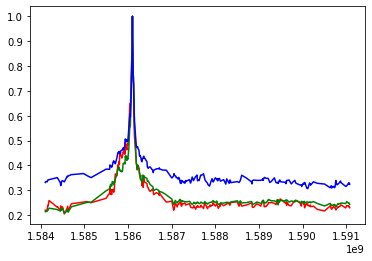

In [13]:
def link_sim(website):
    df = news[news["original_url"] == website]
    diffs = np.eye(len(df) or None, dtype=float)
    counters = [Counter(s.split("\t")) for s in df["links"]]
    for i, c1 in enumerate(counters):
        for j, c2 in enumerate(counters[:i]):
            sim = similarity_coeffs(c1, c2)[2]
            diffs[i][j] = sim
            diffs[j][i] = sim

    return diffs

sitels = "https://www.vg.no:443/"
ls = link_sim(sitels)
print(ls)
loc = len(dd) // 4
plt.plot(list(info_dict[asd]["timestamps"]), dd, color="r")
plt.plot(list(info_dict[asd]["timestamps"]), ls[loc], color="g")
plt.plot(list(info_dict[asd]["timestamps"]), info_dict[asd]["jaccard"]["diffs"][loc], color="b")

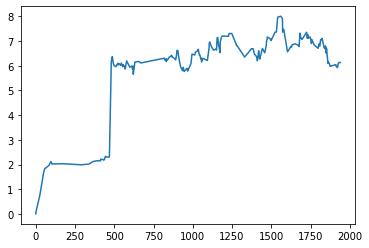

In [14]:
vg = "https://www.hf.no:443/"
tss = np.array(info_dict[vg]["timestamps"])
plt.plot((tss - tss[0]) / 3600, 1/np.array(info_dict[vg]["jaccard"]["diffs"][0])-1)

In [16]:
# !pip install gplearn

     |████████████████████████████████| 41 kB 381 kB/s eta 0:00:011
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [35]:
from gplearn.genetic import SymbolicRegressor

function_set = ['add', 'sub', 'mul', 'div',
                'sqrt', 'log', 'abs', 'neg', 'inv',
                'max', 'min']
sr = SymbolicRegressor(population_size=20000,
                           generations=100, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0,
                      function_set=function_set)
tss = info_dict[vg]["timestamps"]
dfs = info_dict[vg]["jaccard"]["diffs"]
x = np.array([abs(tss[j] - tss[i]) / 3600 for i in range(len(tss)) for j in range(len(tss))])
y = np.array([dfs[j][i] for i in range(len(dfs)) for j in range(len(dfs))])
print(x[:10], y[:10])
print(x[-10:], y[-10:])
sr.fit(np.reshape(x, (-1, 1)) / 3600, y)


[  0.           1.87111111  25.83722222  49.81277778  57.01083333
  82.97555556  96.985      102.93       106.99944444 171.78166667] [1.         0.90606421 0.56910569 0.37466548 0.35299145 0.33809099
 0.32003325 0.3307888  0.3307888  0.32961373]
[59.215      30.18638889 27.09361111 24.23416667 17.07611111 13.145
  8.96833333  6.21944444  1.09166667  0.        ] [0.82161235 0.91992883 0.91992883 0.93048128 0.94265233 0.97106691
 1.         1.         1.         1.        ]
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    17.69          288.624       16        0.0923051        0.0927422    241.24m
   1     7.12          2.61447       16        0.0921155        0.0944484    141.56m
   2     4.57         0.690168        8        0.0911283         0.094011    124.46m
   3     2.67          

  88     1.42         0.783295       24        0.0998753        0.0964705      9.95m
  89     1.42         0.791538        1         0.102846          0.11107      9.14m
  90     1.40         0.972461        7        0.0934751        0.0917585      7.94m
  91     1.41          1.77803       19         0.101195        0.0998636      6.97m
  92     1.41           1.4637        7        0.0931957        0.0974029      6.15m
  93     1.41          1.70322       31        0.0998595         0.102544      5.40m
  94     1.46         0.915087       22         0.100817        0.0980253      4.46m
  95     1.44          1.04407       11         0.101636         0.100213      3.56m
  96     1.42          7.74041       21        0.0925607        0.0941696      2.76m
  97     1.45         0.855679        7         0.102671         0.101934      1.75m
  98     1.45          1.28724        9        0.0955603        0.0966672     53.30s
  99     1.44          9.15771        7        0.0982693         

SymbolicRegressor(function_set=['add', 'sub', 'mul', 'div', 'sqrt', 'log',
                                'abs', 'neg', 'inv', 'max', 'min'],
                  generations=100, max_samples=0.9, p_crossover=0.7,
                  p_hoist_mutation=0.05, p_point_mutation=0.1,
                  p_subtree_mutation=0.1, parsimony_coefficient=0.01,
                  population_size=20000, random_state=0, stopping_criteria=0.01,
                  verbose=1)

In [36]:
print(sr._program)

div(mul(-0.340, X0), mul(-0.894, X0))
